Hello Daniel!

I’m happy to review your project today.
I will mark your mistakes and give you some hints how it is possible to fix them. We are getting ready for real job, where your team leader/senior colleague will do exactly the same. Don't worry and study with pleasure! 

Below you will find my comments - **please do not move, modify or delete them**.

You can find my comments in green, yellow or red boxes like this:

<div class="alert alert-block alert-success">
<b>Reviewer's comment</b> <a class="tocSkip"></a>

Success. Everything is done succesfully.
</div>

<div class="alert alert-block alert-warning">
<b>Reviewer's comment</b> <a class="tocSkip"></a>

Remarks. Some recommendations.
</div>

<div class="alert alert-block alert-danger">

<b>Reviewer's comment</b> <a class="tocSkip"></a>

Needs fixing. The block requires some corrections. Work can't be accepted with the red comments.
</div>

You can answer me by using this:

<div class="alert alert-block alert-info">
<b>Student answer.</b> <a class="tocSkip"></a>

Text here.
</div>

# Machine Learning for Sweet Lift Taxi

* The objective of this task is to create a time series regression model that accurately predicts the number of taxi orders for the next hour. The data provided is a time series which tracks the number of taxi orders over time.
  
* I will process the data, engineer features and train a variety of models.
  
* The main goal is to build a model that returns a prediction on the next hour with an RMSE lower than 48.

In [174]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import arma_order_select_ic, adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from pmdarima import auto_arima
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, make_scorer, root_mean_squared_error

In [4]:
df = pd.read_csv('taxi.csv', index_col = [0], parse_dates = [0])

In [5]:
df.head()

num_orders
datetime                       
2018-03-01 00:00:00           9
2018-03-01 00:10:00          14
2018-03-01 00:20:00          28
2018-03-01 00:30:00          20
2018-03-01 00:40:00          32

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [7]:
df.isna().sum()

num_orders    0
dtype: int64

There are no missing values within the dataframe

# Resampling

* I will resample the data by the sum of orders for each hour

In [10]:
df.sort_index(inplace = True)
df = df.resample('1h').sum()

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: h
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


<div class="alert alert-success">
<b>Reviewer's comment V1</b>

Correct

</div>

# Data Analysis

In [14]:
df.describe()

num_orders
count  4416.000000
mean     84.422781
std      45.023853
min       0.000000
25%      54.000000
50%      78.000000
75%     107.000000
max     462.000000

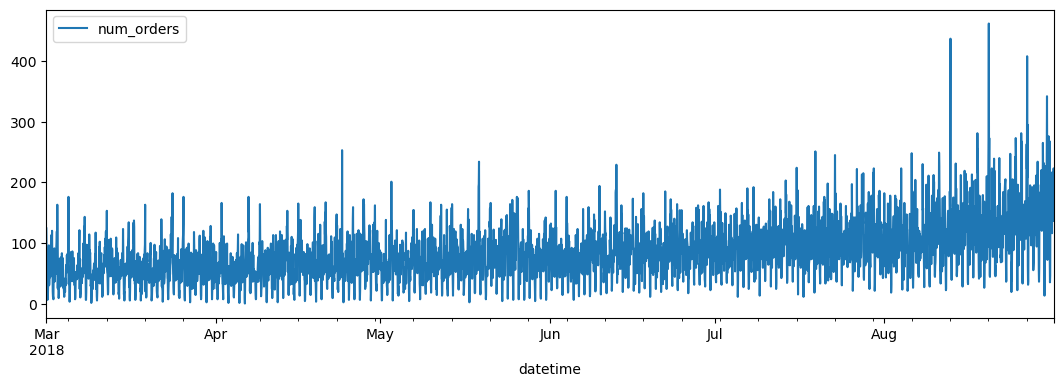

In [15]:
df.plot(figsize = (13,4))
plt.show()

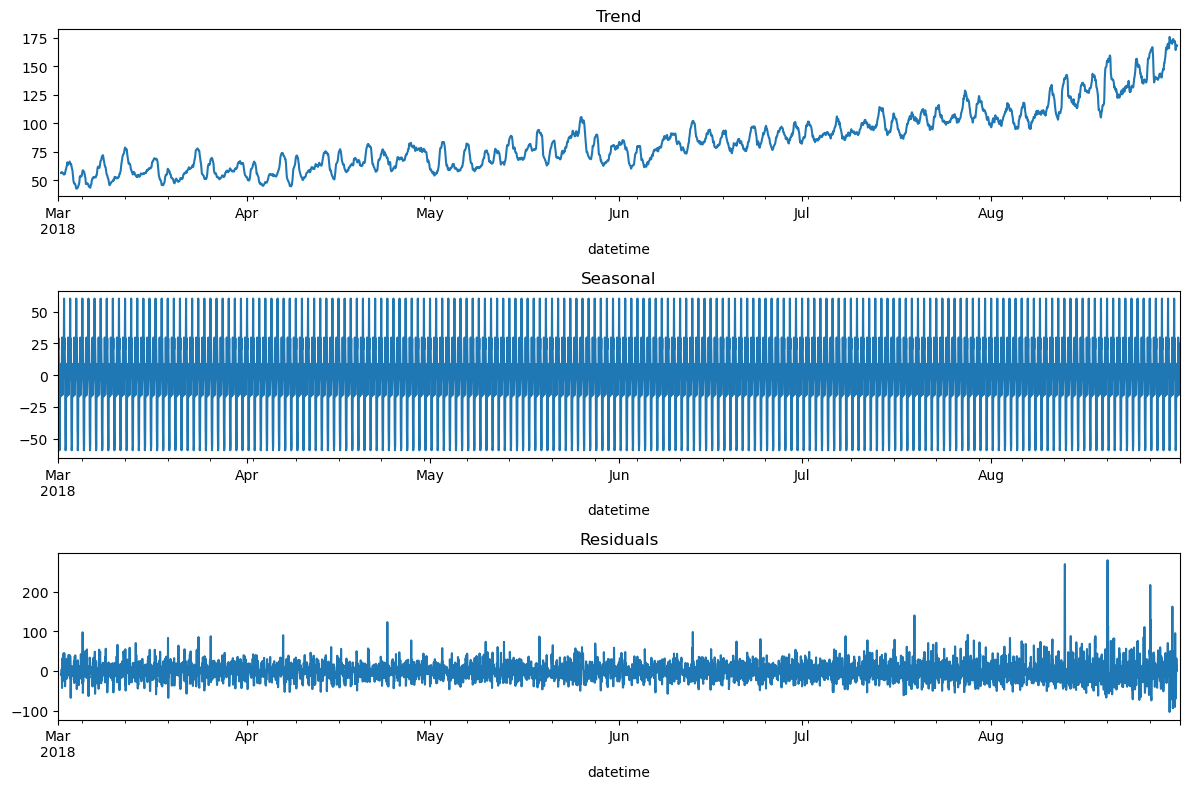

In [16]:
decomposed = seasonal_decompose(df)
plt.figure(figsize = (12, 8))
plt.subplot(311)
decomposed.trend.plot(ax = plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax = plt.gca())
plt.title('Seasonal')
plt.subplot(313)
decomposed.resid.plot(ax = plt.gca())
plt.title('Residuals')
plt.tight_layout()

In [17]:
#taking a slice to zoom in on the trend and seasonl graphs over a two day period
df_slice = df['2018-03-01':'2018-03-2']

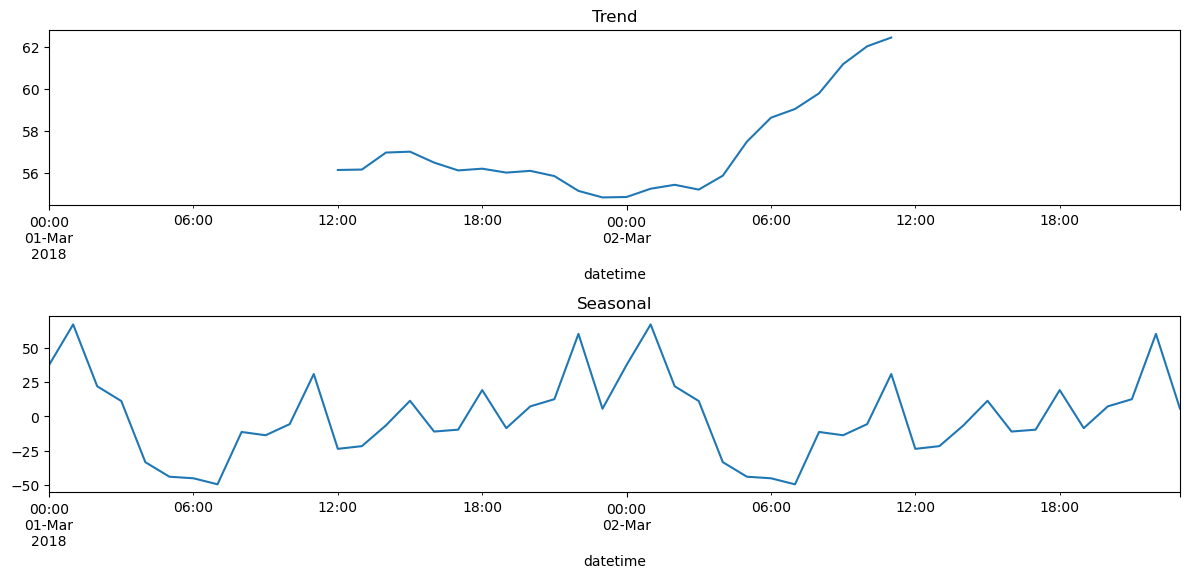

In [18]:
decomposed = seasonal_decompose(df_slice)
plt.figure(figsize = (12, 8))
plt.subplot(311)
decomposed.trend.plot(ax = plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax = plt.gca())
plt.title('Seasonal')
plt.tight_layout()

It seems that there is a somewhat regular seasonal pattern that marks low and peak hours with an overall trend that orders increase throughout both the day and the year.

<div class="alert alert-danger">
<b>Reviewer's comment V1</b>

Good job! But we plot the graphs not just for fun but to draw some conclusions. Graphs without conclusions cost almost nothing. So, please draw a conclusion based on these graphs.

</div>

# Stationarity Test with adfuller

In [22]:
df_stationarity = adfuller(df, autolag = 'AIC')
print('P-Value:', df_stationarity[1])

P-Value: 0.02894005140261486


With a p-value of less than 0.05, the dataset is most likely stationary.

<div class="alert alert-success">
<b>Reviewer's comment V1</b>

Correct

</div>

# Pre-processing and Feature Enginering

In [26]:
def make_features(data, max_lag, rolling):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling, min_periods = 1).mean()

    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    
    return data

df_temp= df.copy()  
df_temp = make_features(df_temp, 4, 10)
df_feat = df_temp.dropna()
display(df_temp.head(4))
display(df_feat.head(4))

num_orders  year  month  day  dayofweek  hour  \
datetime                                                             
2018-03-01 00:00:00         124  2018      3    1          3     0   
2018-03-01 01:00:00          85  2018      3    1          3     1   
2018-03-01 02:00:00          71  2018      3    1          3     2   
2018-03-01 03:00:00          66  2018      3    1          3     3   

                     rolling_mean  lag_1  lag_2  lag_3  lag_4  
datetime                                                       
2018-03-01 00:00:00           NaN    NaN    NaN    NaN    NaN  
2018-03-01 01:00:00    124.000000  124.0    NaN    NaN    NaN  
2018-03-01 02:00:00    104.500000   85.0  124.0    NaN    NaN  
2018-03-01 03:00:00     93.333333   71.0   85.0  124.0    NaN

num_orders  year  month  day  dayofweek  hour  \
datetime                                                             
2018-03-01 04:00:00          43  2018      3    1          3     4   
2018-03-01 05:00:00           6  2018      3    1          3     5   
2018-03-01 06:00:00          12  2018      3    1          3     6   
2018-03-01 07:00:00          15  2018      3    1          3     7   

                     rolling_mean  lag_1  lag_2  lag_3  lag_4  
datetime                                                       
2018-03-01 04:00:00     86.500000   66.0   71.0   85.0  124.0  
2018-03-01 05:00:00     77.800000   43.0   66.0   71.0   85.0  
2018-03-01 06:00:00     65.833333    6.0   43.0   66.0   71.0  
2018-03-01 07:00:00     58.142857   12.0    6.0   43.0   66.0

I created 10 features to use in model training, year, month, day, dayofweek, hour, rolling_mean, and 4 lags.

<div class="alert alert-danger">
<b>Reviewer's comment V1</b>

1. You have a target leakage here. This is the reason of you such good results below. Before to apply method rolling() you should apply method shift() to exclude current observations from moving average. 
2. After you fix target leakage, the quality of your best model will become worse. And to achieve necessary quality you need to create more features like lags and moving averages/dispersions. So, please, do it

</div>

<Axes: xlabel='datetime'>

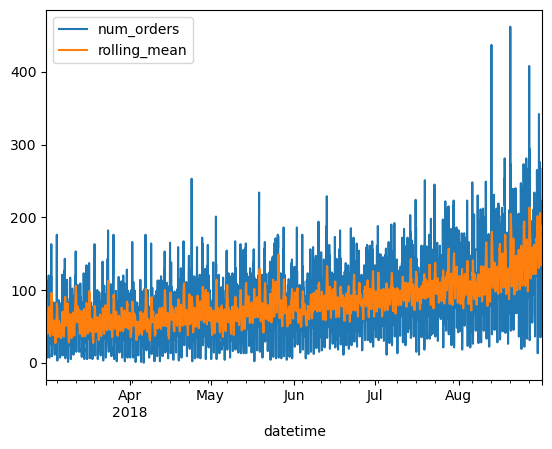

In [28]:
df_feat[['num_orders','rolling_mean']].plot()

In [29]:
train, test = train_test_split(df_feat, shuffle = False, test_size = 0.1)
print(train.shape)
print(test.shape)

(3970, 11)
(442, 11)


In [30]:
#saving only the target column to use in autoregression/ARMA models
train_arma = train['num_orders']
test_arma = test['num_orders']
print(train_arma.shape, test_arma.shape)

#saving a variant of the data set to use in pmdarima

pmd_train_target = train['num_orders'] 
pmd_train_exog = train.drop('num_orders', axis = 1)
test_pmd = test['num_orders']

(3970,) (442,)


<div class="alert alert-success">
<b>Reviewer's comment V1</b>

Correct

</div>

In [32]:
#Separating into features and target sets to train traditional ml models

features = df_feat.drop(['num_orders'], axis = 1)
target = df_feat['num_orders']

feat_train, feat_test, target_train, target_test = train_test_split(features, target, shuffle = False, test_size = 0.1)

print(feat_train.shape, target_train.shape)
print(feat_test.shape, target_test.shape)

(3970, 10) (3970,)
(442, 10) (442,)


<div class="alert alert-danger">
<b>Reviewer's comment V1</b>

You forgot to set `shuffle = False` and thus train and test data are shuffled. This is the second reason of your too good results below.

</div>

# Time Series Regression

I'll create several different time series regression models, first I'll start by plotting ACF and PACF charts.

1. Auto reg
2. Arima
3. PMDARIMA which allows the use of exogenous features.

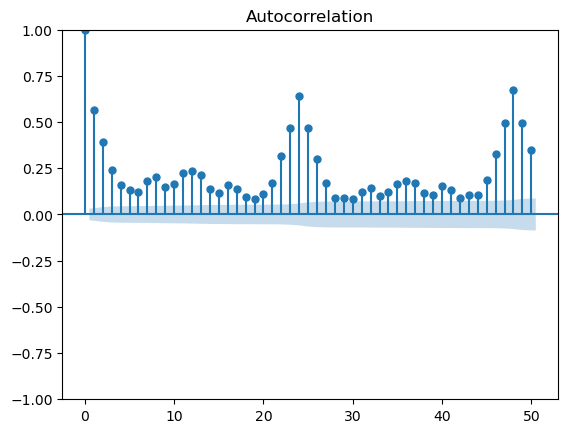

In [39]:
acf = plot_acf(x = train_arma, lags =50, alpha = 0.05)

There are 15 lags until one doesn't completely exceed the confidence interval, MA = 28

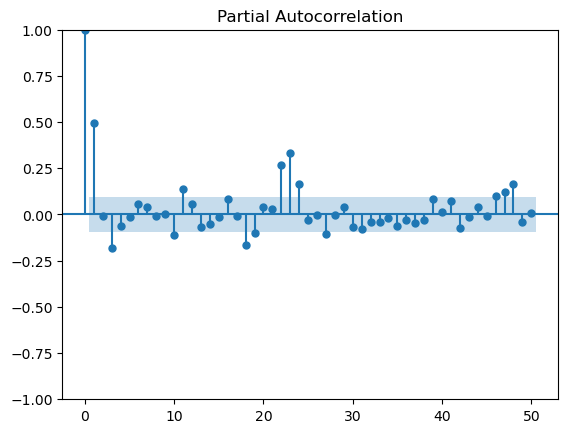

In [41]:
pacf = plot_pacf(x = test_arma, lags = 50, alpha = 0.05)

There are 2 lags until one doesn't exceed the confidence interval, AR = 2. This is a good indication that Auto Regression will be best suited for the data.

# Autoregression with Auto_Reg

In [43]:
mod = ar_select_order(endog = train_arma, maxlag = 2)
ar_order = mod.ar_lags
print(ar_order)

[1, 2]


In [44]:
ar_model_1 = AutoReg(train_arma, lags = ar_order, seasonal = True)
ar_model_1 = ar_model_1.fit()

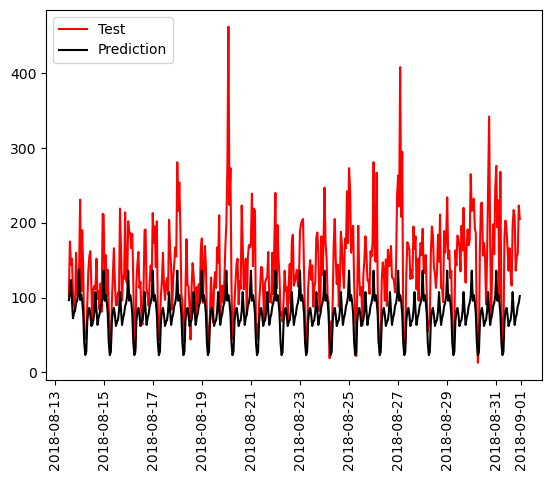

In [45]:
start = len(train_arma)
end= len(train_arma) + len(test_arma) - 1
pred_1 = ar_model_1.predict(start = start, end = end, dynamic = False)

plt.plot(test_arma, color = 'red', label = 'Test')
plt.plot(pred_1, color = 'black', label = 'Prediction')
plt.legend(loc = 'upper left')
plt.xticks(rotation = 90)
plt.show()

In [46]:
rmse_1 = mean_squared_error(test_arma, pred_1) ** 0.5
print('RMSE = ', rmse_1)

RMSE =  75.72143778571436


While this model does seem to understand some of the seasonality of the data, it fails to capture the scale of both the seasonality and the trend thus the RMSE is 75.

<div class="alert alert-danger">
<b>Reviewer's comment V1</b>

RMSE for a single observation means nothing. It can be just a luck. So, the quality of this model is 75 but not 5.3

</div>

<div class="alert alert-block alert-info">
<b>Student answer.</b> <a class="tocSkip"></a>

I agree, however; the instructions for the project were to build a model that predicts the 'next hour'. It seemed relevant that we look at the first hour prediction on the test set as this is the 'next hour' according to the training set. The instructions could have been more clear. Here's the project description I'm referring to, "Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, <b>we need to predict the amount of taxi orders for the next hour. Build a model for such a prediction.<b>"
</div>

<div class="alert alert-danger">
<b>Reviewer's comment V1</b>

RMSE for a single observation means nothing. It can be just a luck. So, the quality of this model is 84 but not 31

</div>

# Auto Regression with ARIMA

In [51]:
res_ar = arma_order_select_ic(y = train_arma, max_ar = 20, max_ma = 0)
ar_order = res_ar.bic_min_order[0]

In [52]:
ar_model = ARIMA(train_arma, order = (ar_order, 0,0))
ar_model = ar_model.fit()

In [53]:
ar_pred = ar_model.predict(start = start, end = end, dynamic = False)

ar_rmse = mean_squared_error(test_arma, ar_pred) ** 0.5

print('ARMA Auto Regression RMSE = ', ar_rmse)

ARMA Auto Regression RMSE =  84.18758807421885


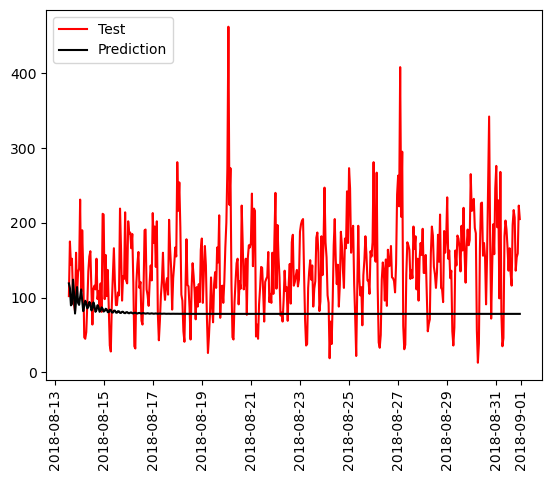

In [54]:
plt.plot(test_arma, color = 'red', label = 'Test')
plt.plot(ar_pred, color = 'black', label = 'Prediction')
plt.legend(loc = 'upper left')
plt.xticks(rotation = 90)
plt.show()

This model performs far worse than the Auto reg model and fails to capture the seasonality of the data. It seems to cluster it's predictions within the first few hours and then stops being able to predict the seasonality. It's RMSE is 84.

<div class="alert alert-danger">
<b>Reviewer's comment V1</b>

RMSE for a single observation means nothing. It can be just a luck. So, the quality of this model is 84 but not 5.7

</div>

# ARMA Model with ARIMA

In [57]:
res_arma = arma_order_select_ic(y = train_arma, max_ar = 2, max_ma = 20)

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarni

In [58]:
bic_ar = res_arma.bic_min_order[0]
bic_ma = res_arma.bic_min_order[1]

In [59]:
bic_model = ARIMA(train_arma, order = (bic_ar, 0, bic_ma))
bic_model = bic_model.fit()

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [60]:
bic_pred = bic_model.predict(start = start, end = end, dynamic = False)

bic_rmse = mean_squared_error(test_arma, bic_pred) ** 0.5

print("BIC ARMA Model RMSE = ", bic_rmse)

BIC ARMA Model RMSE =  82.316628363751


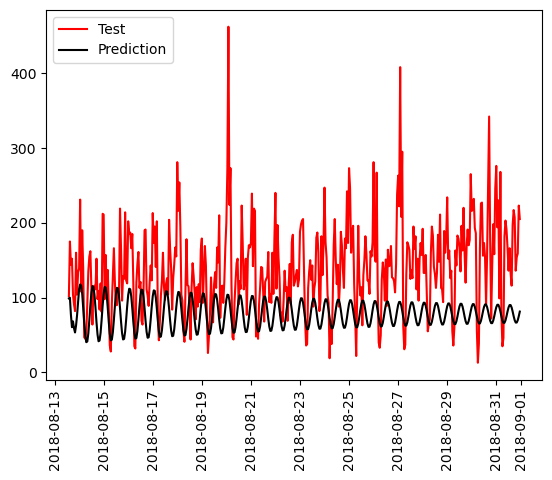

In [61]:
plt.plot(test_arma, color = 'red', label = 'Test')
plt.plot(bic_pred, color = 'black', label = 'Prediction')
plt.legend(loc = 'upper left')
plt.xticks(rotation = 90)
plt.show()

This model only performed slightly better than the AR ARIMA model wth an RMSE of 82.

<div class="alert alert-danger">
<b>Reviewer's comment V1</b>

RMSE for a single observation means nothing. It can be just a luck. So, the quality of this model is 82 but not 6.3

</div>

# PMDARIMA Model

* Since this model can take exogenous features I'll need to prepare a specific set of data for it

In [64]:
pmd_model = auto_arima(y = pmd_train_target, exogenous = pmd_train_exog, seasonal = True, m = 24, scoring = 'mse',
                      start_p = 1, start_d = 1)

In [65]:
pmd_predict = pmd_model.predict(len(test_pmd))
pmd_rmse = mean_squared_error(test_pmd, pmd_predict) ** 0.5

print("pmdarima Model RMSE = ", pmd_rmse)

pmdarima Model RMSE =  57.87815077371108


In [66]:
x = np.zeros(len(df))
x[:len(train_arma)] = np.nan
x[:len(test_arma)] = pmd_predict

df['predicted_order'] = x

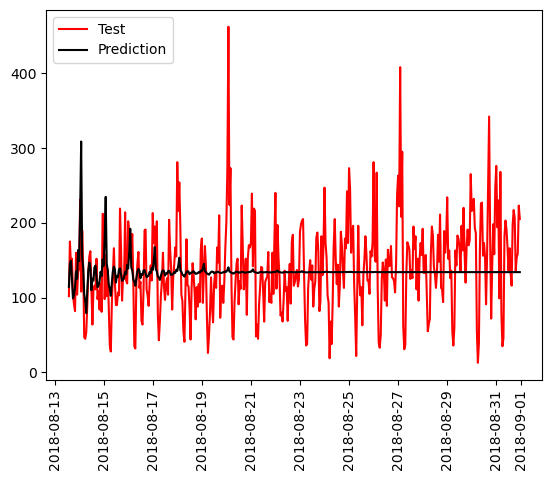

In [168]:
plt.plot(test_arma, color = 'red', label = 'Test')
plt.plot(pmd_predict, color = 'black', label = 'Prediction')
plt.legend(loc = 'upper left')
plt.xticks(rotation = 90)
plt.show()

While this model's RMSE is the best of the time series regression models at 57 and seems to initially capture the seasonality of the data fairly well, it quickly proves to be underfitted and stops being able to make accurate predictions after the first few hours.

<div class="alert alert-danger">
<b>Reviewer's comment V1</b>

RMSE for a single observation means nothing. It can be just a luck. So, the quality of this model is 57 but not 12

</div>

# Traditional ML Models

I'll build five different models

1. Linear Regression
2. Decision Tree Regressor
3. Random Forest Regressor
4. LightGBM Gradient Boosted Decision Tree
5. Light GBM Random Forest

# Linear Regression

* I'll create a linear regression model in-order to have something to compare the other models to

In [156]:
linear_model = LinearRegression()
linear_model.fit(feat_train, target_train)

LinearRegression()

In [158]:
pred = linear_model.predict(feat_test)

rmse = mean_squared_error(target_test, pred) ** 0.5

print("Linear Regression Model RMSE = ", rmse)

Linear Regression Model RMSE =  53.11756885433393


This is already an improvement over the time series regression models.

# Decision Tree Regressor

In [176]:
rmse_scorer = make_scorer(root_mean_squared_error, greater_is_better = False)

In [180]:
seed = 12345
tscv = TimeSeriesSplit(n_splits = 3)
dt_model = DecisionTreeRegressor(random_state = seed, criterion = 'squared_error', splitter = 'best')
grid = {'max_depth':np.arange(7,25,2), 'min_samples_leaf':np.arange(4, 12, 2), 'min_samples_split':[50,100,150,200]}

In [182]:
dt_gridsearch = GridSearchCV(estimator = dt_model, param_grid = grid, cv = tscv, scoring = rmse_scorer, n_jobs = 8, verbose = 1)
dt_gridsearch.fit(feat_train, target_train)

Fitting 3 folds for each of 144 candidates, totalling 432 fits


/opt/anaconda3/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=DecisionTreeRegressor(random_state=12345), n_jobs=8,
             param_grid={'max_depth': array([ 7,  9, 11, 13, 15, 17, 19, 21, 23]),
                         'min_samples_leaf': array([ 4,  6,  8, 10]),
                         'min_samples_split': [50, 100, 150, 200]},
             scoring=make_scorer(root_mean_squared_error, greater_is_better=False, response_method='predict'),
             verbose=1)

In [184]:
best_params = dt_gridsearch.best_params_
best_score = dt_gridsearch.best_score_

print(f'''Best Score = {best_score}\n
Best Parameters: {best_params}''')

Best Score = -30.188952746690518

Best Parameters: {'max_depth': 11, 'min_samples_leaf': 4, 'min_samples_split': 50}


In [186]:
final_dt = DecisionTreeRegressor(random_state = seed, criterion = 'squared_error', splitter = 'best', max_depth = 11, min_samples_leaf = 4, 
                                min_samples_split = 50).fit(feat_train, target_train)

dt_pred = final_dt.predict(feat_test)
dt_rmse = mean_squared_error(target_test, dt_pred) ** 0.5
print('Decision Tree RMSE = ', dt_rmse)

Decision Tree RMSE =  48.11692184223142


This Decision Tree Model was a significant improvement over the time series models and over Linear Regression, however, the RMSE is still too high to be acceptable.

# Random Forest Model

In [188]:
rf_model = RandomForestRegressor(random_state = seed, criterion = 'squared_error')
rf_grid = {'n_estimators':np.arange(20,50,5), 'max_depth':np.arange(10,24,2),
           'min_samples_leaf':[6,8,10,12],'max_features':['sqrt','log2',None]}

In [190]:
rf_gridsearch = GridSearchCV(estimator = rf_model, param_grid = rf_grid, cv = tscv, scoring = rmse_scorer, n_jobs = 8, verbose = 1)
rf_gridsearch.fit(feat_train, target_train)

Fitting 3 folds for each of 504 candidates, totalling 1512 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=RandomForestRegressor(random_state=12345), n_jobs=8,
             param_grid={'max_depth': array([10, 12, 14, 16, 18, 20, 22]),
                         'max_features': ['sqrt', 'log2', None],
                         'min_samples_leaf': [6, 8, 10, 12],
                         'n_estimators': array([20, 25, 30, 35, 40, 45])},
             scoring=make_scorer(root_mean_squared_error, greater_is_better=False, response_method='predict'),
             verbose=1)

In [191]:
best_rf_params = rf_gridsearch.best_params_
best_rf_score = rf_gridsearch.best_score_

print(f'''Best Score = {best_rf_score}\n
Best Parameters: {best_rf_params}''')

Best Score = -27.72077151338752

Best Parameters: {'max_depth': 16, 'max_features': None, 'min_samples_leaf': 6, 'n_estimators': 40}


In [194]:
final_rf = RandomForestRegressor(random_state = seed, criterion = 'squared_error', max_depth = 16,
                                n_estimators = 40, min_samples_leaf = 6, max_features = None).fit(feat_train, target_train)

rf_pred = final_rf.predict(feat_test)

rf_rmse = mean_squared_error(target_test, rf_pred) ** 0.5

print('Random Forest RMSE = ', rf_rmse)

Random Forest RMSE =  46.82258806297444


This is an acceptable score of 46 and shows an improvement over the decision tree. 

# Light GBM

* GBDT Model
* RF Model

In [197]:
gbm_dt_model = lgb.LGBMRegressor(boosting_type='gbdt',random_state=seed,metric='rmse',n_estimators=1000)
gbm_dt_grid = {'max_depth': np.arange(7,25,2),'num_leaves': [8, 10, 12],'learning_rate': [0.01, 0.05]}

In [199]:
dt_gbm_search = GridSearchCV(estimator = gbm_dt_model, param_grid = gbm_dt_grid, cv = tscv, n_jobs = 8, verbose = False)
dt_gbm_search.fit(feat_train, target_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000646 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 776
[LightGBM] [Info] Number of data points in the train set: 994, number of used features: 9
[LightGBM] [Info] Start training from score 56.971831
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=LGBMRegressor(metric='rmse', n_estimators=1000,
                                     random_state=12345),
             n_jobs=8,
             param_grid={'learning_rate': [0.01, 0.05],
                         'max_depth': array([ 7,  9, 11, 13, 15, 17, 19, 21, 23]),
                         'num_leaves': [8, 10, 12]},
             verbose=False)

In [203]:
dt_gbm_score = dt_gbm_search.best_score_
dt_gbm_params = dt_gbm_search.best_params_

print(f'''Best Score = {dt_gbm_score}\n
Best Parameters: {dt_gbm_params}''')

Best Score = 0.44487029237803283

Best Parameters: {'learning_rate': 0.01, 'max_depth': 7, 'num_leaves': 12}


In [205]:
final_gbm_dt = lgb.LGBMRegressor(bosting_type = 'gbdt', random_state = seed, metric = 'rmse', n_estimators = 1000,
                                max_depth = 7, num_leaves = 12, learning_rate = 0.01).fit(feat_train, target_train)

gbm_dt_pred = final_gbm_dt.predict(feat_test)
gbm_dt_rmse = mean_squared_error(target_test, gbm_dt_pred) ** 0.5

print('LightGBM gbdt RMSE = ', gbm_dt_rmse)

[LightGBM] [Warning] Unknown parameter: bosting_type
[LightGBM] [Warning] Unknown parameter: bosting_type
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000404 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1085
[LightGBM] [Info] Number of data points in the train set: 3970, number of used features: 9
[LightGBM] [Info] Start training from score 78.282368
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Unknown parameter: bosting_type
LightGBM gbdt RMSE =  44.037308767679626


Gradient boosting seems to be the most effective method for building a model on this data, the gbdt model returned an RMSE of 44.

In [207]:
gbm_rf_model =lgb.LGBMRegressor(boosting_type='rf',random_state=seed, metric='rmse',bagging_fraction=0.9,
                                bagging_freq = 5, lambda_l1 = 0.1, lambda_l2 = 0.1, feature_fraction = 0.9)
gbm_rf_grid = {'max_depth':np.arange(10,20,2),'learning_rate':[0.01, 0.05],'n_estimators':np.arange(10,50,5),
               'num_leaves':np.arange(10,100,10)}

In [209]:
rf_gbm_search = GridSearchCV(estimator = gbm_rf_model, param_grid = gbm_rf_grid, scoring = rmse_scorer, cv = tscv, n_jobs = 8, verbose = False)
rf_gbm_search.fit(feat_train, target_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000681 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 1986, number of used features: 9
[LightGBM] [Info] Start training from score 63.185801
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000665 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 776
[LightGBM] [Info] Number of data points in the train set: 994, number of used features: 9
[LightGBM] [Info] Start training from score 56.971831
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000614 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 1986, number of used features: 9
[LightGBM] [Info] Start training fr

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=LGBMRegressor(bagging_fraction=0.9, bagging_freq=5,
                                     boosting_type='rf', feature_fraction=0.9,
                                     lambda_l1=0.1, lambda_l2=0.1,
                                     metric='rmse', random_state=12345),
             n_jobs=8,
             param_grid={'learning_rate': [0.01, 0.05],
                         'max_depth': array([10, 12, 14, 16, 18]),
                         'n_estimators': array([10, 15, 20, 25, 30, 35, 40, 45]),
                         'num_leaves': array([10, 20, 30, 40, 50, 60, 70, 80, 90])},
             scoring=make_scorer(root_mean_squared_error, greater_is_better=False, response_method='predict'),
             verbose=False)

In [210]:
rf_gbm_score = rf_gbm_search.best_score_
rf_gbm_params = rf_gbm_search.best_params_

print(f'''Best Score = {rf_gbm_score}\n
Best Parameters: {rf_gbm_params}''')

Best Score = -28.505239538507343

Best Parameters: {'learning_rate': 0.01, 'max_depth': 12, 'n_estimators': 40, 'num_leaves': 80}


In [213]:
final_gbm_rf = lgb.LGBMRegressor(boosting_type = 'rf', random_state = seed, metric = 'rmse', bagging_fraction = 0.9,
                                bagging_freq = 5, lambda_l1 = 0.1, lambda_l2 = 0.1, feature_fraction = 0.9, 
                                max_depth = 12, n_estimators = 40, num_leaves = 80, learning_rate = 0.01).fit(feat_train, target_train)

gbm_rf_pred = final_gbm_rf.predict(feat_test)
gbm_rf_rmse = mean_squared_error(target_test, gbm_rf_pred) ** 0.5

print('LightGBM rf RMSE = ', gbm_rf_rmse)

[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fract

The LightGBM rf model performed similarly to the traditional decision tree model. This makes sense as gradient boosting the decision tree really improved the rmse with the gbdt model while the rf model doesn't use gradient boosting.

* Conclusion

After performing and adfuller test on the data, the test returned a p-value of 0.02 which confirms that the time series is very likely stationary. 

I engineered 10 features from the data provided, year, month, day, hour, dayofweek, rolling mean, and four lags.

<b> Time Series Regression Model Training <b>

* <b> Auto Reg <b>

    - Auto Regression with Auto Reg returned an RMSE of 75.

* <b> ARIMA Auto Regression <b>

    - This model was built using only the ar order parameter and it returned an overall RMSE of 84.

* <b> ARMA Model With ARIMA <b>

    - I decided to build an Auto Regression/Moving Average model with ARIMA just to see how much including the moving average might improve predictions. The result wasn't promising as the RMSE was 82, though there was one caveat, the computational expense limited my ability to train a deeper, more complex model, with a more powerful computer this result certainly could be improved.
 
* <b> PMDARIMA Model <b>

    - The final time series regression model I built was an auto arima model from PMDARIMA. I wanted to be able to use the exogenous features I engineered to see how this might affect the predictions. This proved to be a much better model over the other time series models with an RMSE of 57, however; this is still too high to be acceptable.

None of the time Series models seemed to be able to capture the seasonality and the scale of the data, especially past a few hours after training. This seemed to be the main limitation. 

<b> Machine Learning Model Training <b>

I used all of the engineered features to train these models.

* <b> Linear Regression <b>

    - Linear Regressrion performed better than all of the Time series models with an RMSE of 53.
      

* <b> Decision Tree Regressor <b>

    - A significant improvement over Linear Regression with an RMSE of 48.1, still slightly too high to be acceptable.
      

* <b> Random Forest Regressor <b>

    - With an RMSE of 46, this model performs well enough to be passable though there was still room to improve.
      
      
* <b> LightGBM Gradient Boosted Decision Tree <b>

    - The best model out of all of them, this model returned and RMSE of 44.
      

* <b> LightGBM Random Forest <b>

    - Surprisingly, this model was outperformed by the traditional sklearn Random Forest and returned an RMSE of 49.
      
 
<b> Conclusion <b>

While none of the time series models performed well enough to meet the required RMSE of 48 or less, a couple of the traditional machine learning models exceeded the requirement. Both the sklearn Random Forest Regressor and the LightGBM gbdt models returned and RMSE less than 48 with the best of the two being the LightGBM gbdt model which had an RMSE of 44. This is clearly the best suited model for predicting the number of taxi orders for the next hour.

<div class="alert alert-danger">
<b>Reviewer's comment V1</b>

1. You have several mistakes above due to it you got unrealistic good quality for the linear regression model.
2. After you fix all the mistakes, the quality will be much lower. To achieve necessary quality you need to create more features and try other classical ML models.
3. You can't use a RMSE for a single observation as measure for model quality. It can be just a luck. Moreover, you need to make predictions for more steps in future than just one.
4. You need to tune hyperparameters at least for one model. Keep in mind that when you work with time series, you can't use default data splitter from GridSearchCV becasue default splitter shuffles the data. You should use the special time series splitter: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html

</div>